# Compare against other tools

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interpn
import warnings

In [2]:
hfont = {'fontname':'Arial', 'size':10}

dark_blue = '#17212b'
light_blue = '#3dc5ef'
teal= '#42dee1'
green = '#6eecb9'
yellow = '#eef5b3'

figsize= (2.363,2.363)

def density_scatter( x , y, ax = None, sort = True, bins = 30, cmap = 'turbo', **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    Adapted from https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
    """

    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, cmap=cmap, **kwargs )

    return ax

def add_species_column(prot_df_mq):
    if 'Species' in prot_df_mq.keys():
        return
    prots = prot_df_mq["Protein IDs"]
    species = []
    for prot in prots:
        if "_ECO" in prot:
            species.append('Escherichia coli')
        elif "HUMAN" in prot:
            species.append("Homo sapiens")
        else:
            species.append("X")
    prot_df_mq['Species'] = species
    
def add_species_column_(prot_df_mq):
    if 'Species' in prot_df_mq.keys():
        return
    prots = prot_df_mq["Protein"]
    species = []
    for prot in prots:
        if "_ECO" in prot:
            species.append('Escherichia coli')
        elif "HUMAN" in prot:
            species.append("Homo sapiens")
        else:
            species.append("X")
    prot_df_mq['Species'] = species
    
def get_plot_df(ref, base_columns, ratio_columns, ax, id_, text_pos, valid_filter = True):

    to_plot = pd.DataFrame()
    ref[base_columns] = ref[base_columns].replace(0, np.nan)
    ref[ratio_columns] = ref[ratio_columns].replace(0, np.nan)
    to_plot['Species'] = ref['Species']

    to_plot['base'] = ref[base_columns].median(axis=1)
    to_plot['ratio'] = ref[ratio_columns].median(axis=1)
    to_plot['base_cnt'] = ref[base_columns].notna().sum(axis=1)
    to_plot['ratio_cnt'] = ref[ratio_columns].notna().sum(axis=1)

    to_plot['ratio_'] = np.log2(to_plot['base'] / to_plot['ratio'])
    to_plot['sum_'] = np.log2(to_plot['ratio'])

    if valid_filter:
        valid = to_plot.query(f'ratio_cnt >= 2 and base_cnt >=2')
    else:
        valid = to_plot.query(f'ratio_cnt >0 and base_cnt >0')

    homo = valid[valid['Species'] == 'Homo sapiens']
    e_coli = valid[valid['Species'] == 'Escherichia coli']

    homo_ratio = homo['ratio_'].values
    e_coli_ratio = e_coli['ratio_'].values

    #ax = density_scatter(homo['ratio_'].values, homo['sum_'].values, ax, bins=20, cmap='Reds', alpha=0.5)
    #ax = density_scatter(e_coli['ratio_'].values, e_coli['sum_'].values, ax, bins=20, cmap='Blues', alpha=0.5)
    
    ax.plot(homo['ratio_'], homo['sum_'], '.', alpha=0.5, color = light_blue, markersize=1)
    ax.plot(e_coli['ratio_'], e_coli['sum_'], '.', alpha=0.5, color = dark_blue, markersize=1)
    
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        homo_ratio_median = np.nanmedian(homo_ratio[~np.isinf(homo_ratio)])
        e_coli_ratio_median = np.nanmedian(e_coli_ratio[~np.isinf(e_coli_ratio)])

        homo_ratio_std = np.nanstd(homo_ratio[~np.isinf(homo_ratio)])
        e_coli_ratio_std = np.nanstd(e_coli_ratio[~np.isinf(e_coli_ratio)])
        
    
    #print(f'Homo {std_:.2f}')
    
    
    ecoli_std = e_coli['ratio_'].std()
    homo_std = homo['ratio_'].std()
    

    ax.text(text_pos[0], text_pos[1], f'Homo \n{len(homo):,}\nStd \n{homo_std:.2f}', **hfont)
    ax.text(text_pos[2], text_pos[3], f'E. coli\n{len(e_coli):,} \nStd \n{ecoli_std:.2f}', **hfont)
    

    #ax.set_title(f'{id_} {nl} Homo (median, std) {homo_ratio_median:.2f}, {homo_ratio_std:.2f} {nl} EColi (median, std) {e_coli_ratio_median:.2f}, {e_coli_ratio_std:.2f} {nl} {valid["Species"].value_counts().to_dict()}')


In [3]:

mq_files = ['F:/AP_Paper_Benchmark/PXD006109_Thermo_MaxQuant/combined/txt',
            'F:/AP_Paper_Benchmark/PXD010012_Bruker_MaxQuant/combined/txt']

mq_col_names = [('HeLa2', 'HeLa12', 3),
                ('Base', 'Ratio', 5)]

ms_files = ['F:/AP_Paper_Benchmark/PXD006109_Thermo_MSFragger/combined_protein.tsv',
            'F:/AP_Paper_Benchmark/PXD010012_Bruker_MSFragger/combined_protein.tsv']

ms_col_names = [('HeLa2', 'HeLa12', 3),
                ('Base', 'Ratio', 5),
               ]

ap_files = ['F:/AP_Paper_Benchmark/PXD006109_Thermo_AlphaPept/results.hdf',
            'F:/AP_Paper_Benchmark/PXD010012_Bruker_AlphaPept/results.hdf']

ap_col_names = [('PXD006109_HeLa2', 'PXD006109_HeLa12', 3),
                ('Base', 'Ratio', 5),
               ]

In [4]:
def load_maxquant(file):
    
    df_mq = pd.read_csv(file, sep='\t')
    
    no_rev_cont = [(x[0]!="+") & (x[1] !="+") for x in df_mq[["Reverse","Potential contaminant"]].values]
    df_mq = df_mq[no_rev_cont]
    add_species_column(df_mq)
    
    df_mq['Species'] = df_mq['Species'].replace(np.nan, "X")
    
    return df_mq

def load_msfragger(file):
    
    df_mf = pd.read_csv(file, sep='\t') 
    add_species_column_(df_mf)
    df_mf['Species'] = df_mf['Species'].replace(np.nan, "X")
    
    return df_mf

def load_alphapept(file):
    df_ap = pd.read_hdf(file, 'protein_table')
    df_ap.columns = [os.path.split(_)[1].replace('.ms_data.hdf','') for _ in df_ap.columns]

    species = []
    for _ in df_ap.index:
        if 'HUMAN' in _:
            species.append('Homo sapiens')
        elif 'ECO' in _:
            species.append('Escherichia coli')
        else:
            species.append('X')

    df_ap['Species'] = species
    
    
    df_ap = df_ap[~df_ap.index.str.contains('REV__')]
    
    return df_ap


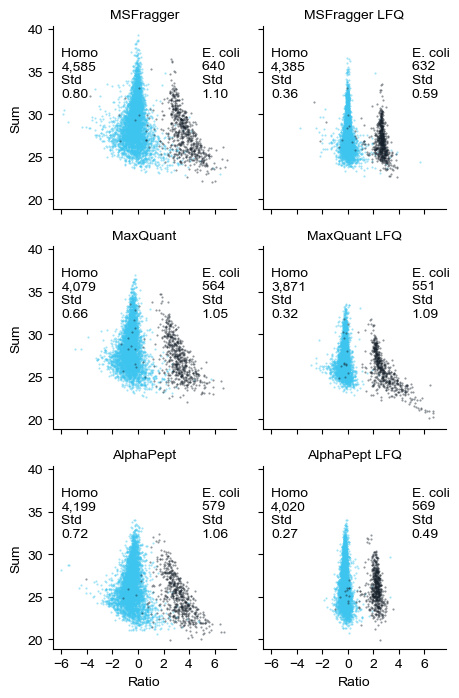

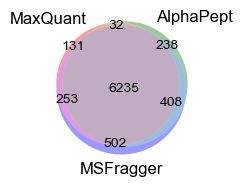

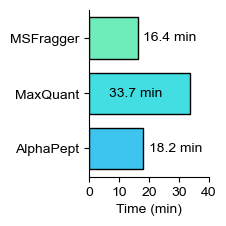

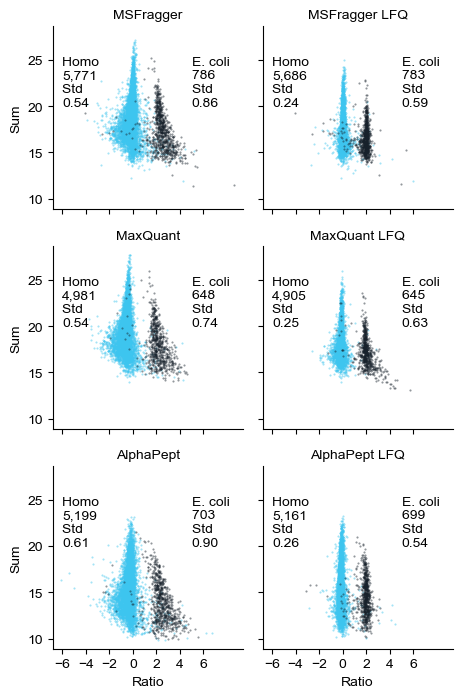

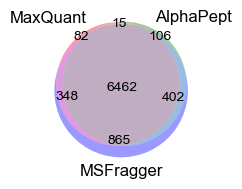

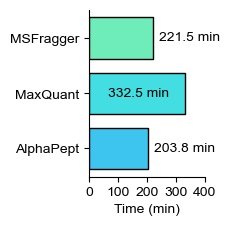

In [25]:
from matplotlib_venn import venn3, venn3_circles

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

plt.rc('font',**{'family':'serif','serif':['Arial'], 'size':10})

text_poses = [(-6, 32, 5, 32), (-6, 20, 5, 20)]

"""
Manually read
MSFrager: 16.4 minutes | 221.5 Minutes
AlphaPept: 18.2 minutes | 203.8 minutes | 
MaxQuant: 33.7 | 332.5
"""

colors = [light_blue, teal, green, yellow]

timings = ([16.4, 33.7, 18.2], [221.5, 332.5, 203.8])
timing_labels = ['MSFragger', 'MaxQuant','AlphaPept']

for experiment_idx, experiment_id in enumerate(['PXD006109_Thermo', 'PXD010012_Bruker']):
    
    df_mq = load_maxquant(os.path.join(mq_files[experiment_idx],'proteinGroups.txt'))
    df_mf = load_msfragger(ms_files[experiment_idx])
    df_ap = load_alphapept(ap_files[experiment_idx])
    
    fig, axes = plt.subplots(3, 2, figsize=(2*figsize[0],3*figsize[0]), sharex=True, sharey=True)

    for j, _ in enumerate(['noLFQ','LFQ']):
        if _ == 'LFQ':
            x = 'MaxLFQ I'
        else:
            x = 'I'
             
        base_prefix, ratio_prefix, file_range = ms_col_names[experiment_idx]

        base_columns = [f"{base_prefix}_{i} {x}ntensity" for i in range(1,file_range+1)]
        ratio_columns = [f"{ratio_prefix}_{i} {x}ntensity" for i in range(1,file_range+1)]

        id_ = 'MSFragger ' +'_ '+experiment_id
        get_plot_df(df_mf, base_columns, ratio_columns, axes[0,j], id_, text_poses[experiment_idx])

    for j, _ in enumerate(['noLFQ','LFQ']):
        if _ == 'LFQ':
            x = 'LFQ i'
        else:
            x = 'I'
            
        base_prefix, ratio_prefix, file_range = mq_col_names[experiment_idx]

        base_columns = [f"{x}ntensity {base_prefix}_{i}" for i in range(1,file_range+1)]
        ratio_columns = [f"{x}ntensity {ratio_prefix}_{i}" for i in range(1,file_range+1)]

        id_ = 'MaxQuant ' +'_ '+experiment_id
        get_plot_df(df_mq, base_columns, ratio_columns, axes[1,j], id_, text_poses[experiment_idx])


    for j, _ in enumerate(['noLFQ','LFQ']):
        if _ == 'LFQ':
            x = '_LFQ'
        else:
            x = ''
            
        base_prefix, ratio_prefix, file_range = ap_col_names[experiment_idx]

        base_columns = [f"{base_prefix}_{i}{x}" for i in range(1,file_range+1)]
        ratio_columns = [f"{ratio_prefix}_{i}{x}" for i in range(1,file_range+1)]
        
        if experiment_idx == 1:
            base_columns = [f"PXD010012_CT_{i}_C1_01_Base{x}" for i in range(1,file_range+1)]
            ratio_columns = [f"PXD010012_CT_{i}_C2_01_Ratio{x}" for i in range(1,file_range+1)]

        id_ = 'AlphaPept ' +'_ '+experiment_id
        get_plot_df(df_ap, base_columns, ratio_columns, axes[2,j], id_, text_poses[experiment_idx])
            
    
    for col in range(1):
        for row in range(3):
           
            ax = axes[row,col]
            ax.set_xticks([-6,-4,-2,0,2,4,6])
            ax.set_ylabel('Sum', **hfont)
            ax.set_title(id_, **hfont)
            
    axes[0,0].set_title('MSFragger', **hfont)
    axes[1,0].set_title('MaxQuant', **hfont)
    axes[2,0].set_title('AlphaPept', **hfont)
    
    axes[0,1].set_title('MSFragger LFQ', **hfont)
    axes[1,1].set_title('MaxQuant LFQ', **hfont)
    axes[2,1].set_title('AlphaPept LFQ', **hfont)
    
    axes[2,0].set_xlabel('Ratio', **hfont)
    axes[2,1].set_xlabel('Ratio', **hfont)
    plt.tight_layout()
    
    #fig.suptitle(experiment_id + '\n no LFQ           LFQ', **hfont) # or plt.suptitle('Main title')
    #fig.subplots_adjust(top=0.88)
    
    plt.xticks(**hfont)
    plt.yticks(**hfont)
    plt.savefig(f'./figures/08_{experiment_id}.pdf')  
    plt.show()     
    print('='*30)
    
    
    
    fig, ax = plt.subplots(figsize=figsize)
    
    mq_prot = set(df_mq['Majority protein IDs'].apply(lambda x : x.split(';')[0]))
    ap_prot = set(pd.DataFrame(df_ap.index)[0].apply(lambda x : x.split(';')[0]))
    mf_prot = set(df_mf['Protein'].apply(lambda x : x.split(';')[0]))

    
    venn3([mq_prot, ap_prot, mf_prot], ('MaxQuant', 'AlphaPept', 'MSFragger'), ax=ax)
    
    plt.tight_layout()
    plt.savefig(f'./figures/08_{experiment_id}_venn.pdf') 

    plt.show()
    

        
    plt.figure(figsize=(2.363,2.363)) #60x60
    height=0.75
    data = timings[experiment_idx][::-1]
    text = [f"{data[idx]} min" for idx, _ in enumerate(timing_labels[::-1])]

    for i in range(len(data)): 
        t = data[i]
        plt.barh(timing_labels[::-1][i], t, height, color = colors[i], linewidth=1, edgecolor='black')
        
        if i == 1:
            plt.text(t*0.2, i, text[i], **hfont, va='center')
        else:
            plt.text(t*1.1, i, text[i], **hfont, va='center')

    plt.xlabel('Time (min)', **hfont)    
    if experiment_idx == 0:
        plt.xticks([0, 10, 20, 30, 40])
    else:
        plt.xticks([0, 100, 200, 300, 400])
        
    plt.xticks(**hfont)
    plt.tight_layout()
    plt.savefig(f'./figures/08_{experiment_id}_time.pdf') 
    
    plt.show()
    